# Titanic: Machine Learning from Disaster

**The sinking of the Titanic is one of the most infamous shipwrecks in history.**

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this notebook,I build a predictive model that answers the question: “what sorts of people were more likely to survive?”, using passenger data such as name, age, gender, socio-economic class, etc.

## Overview
* Import Libraries
* Feature Engineering
    * 

## Import libraries
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualisation and plotting tools
import scipy
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/test.csv
./data/train.csv


In [2]:
import data_clean # the cleaning function that was built using the exploration notebook

train_df = pd.read_csv('./data/train.csv')#'/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('./data/test.csv')#'/kaggle/input/titanic/test.csv')

train_df.loc[:,'train'] = 1
test_df.loc[:,'train'] = 0
test_df.loc[:,'Survived'] = np.nan
df = pd.concat((train_df,test_df), ignore_index = True)

all_cat = True
df = data_clean.clean(df, all_cat = all_cat)
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'train',
       'Ticket_unique', 'Title', 'Num_cabins', 'Cabin_letter', 'Group_size'],
      dtype='object')

In [3]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)
if all_cat == True:
    encoder.fit(df[df.train == 1].drop(['Survived','train'], axis = 1))    # Assume for simplicity all features are categorical.
else:
    encoder.fit(df[df.train == 1].drop(['Survived','train','Age','Fare'], axis = 1))  
    scaler = StandardScaler()
    scaler.fit(df[df.train == 1][['Age','Fare']])
    

# Apply the encoder.
if all_cat == True:
    X_train = encoder.transform(df[df.train == 1].drop(['Survived','train'], axis = 1))
else:
    X_train_cat = encoder.transform(df[df.train == 1].drop(['Survived','train','Age','Fare'], axis = 1))
    X_train_cont = scaler.transform(df[df.train == 1][['Age','Fare']])
    X_train = np.concatenate([X_train_cat,X_train_cont], axis = 1)
#X_test

y_train = df[df.train==1].Survived

X_train.shape

(888, 47)

In [4]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print('Gaussian Naive Bayes')
print(cv)
print(cv.mean())

lr = LogisticRegression(max_iter = 2000, C = 1.2, solver = 'liblinear')
cv = cross_val_score(lr,X_train,y_train,cv=5)
print('\nLogistic Regression')
print(cv)
print(cv.mean())

svc = SVC(kernel = 'rbf', probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print('\nSupport Vector Classification')
print(cv)
print(cv.mean())

gbc = GradientBoostingClassifier()
cv = cross_val_score(gbc,X_train,y_train,cv=5)
print('\nGBC')
print(cv)
print(cv.mean())

rfc = RandomForestClassifier()
cv = cross_val_score(rfc,X_train,y_train,cv=5)
print('\nRFC')
print(cv)
print(cv.mean())

Gaussian Naive Bayes
[0.62359551 0.7247191  0.52808989 0.51977401 0.55367232]
0.5899701644131277

Logistic Regression
[0.80337079 0.82022472 0.81460674 0.81920904 0.83615819]
0.8187138957658858

Support Vector Classification
[0.83707865 0.80898876 0.83146067 0.8079096  0.85310734]
0.8277090078080367

GBC
[0.80898876 0.79213483 0.83707865 0.79096045 0.86440678]
0.8187138957658859

RFC
[0.79775281 0.76404494 0.83146067 0.7740113  0.85310734]
0.8040754142068177


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

cv = 5
params = [
            {
                'clf': [LogisticRegression(max_iter=1000)],
                'clf__solver' : ['liblinear'],
                'clf__penalty' : ['l1','l2'],
            #    'clf__C': [0.001, 0.1, 1, 10, 100, 1000],
            },
            {
                'clf': [LogisticRegression(max_iter=1000)],
                'clf__solver': ['lbfgs'],
                'clf__penalty': ['l2'],
             #   'clf__C': [0.001, 0.1, 1, 10, 100, 1000],
            },
            {
                'clf': [SVC(probability=True)],
                'clf__kernel': ['poly', 'rbf', 'sigmoid','linear'],
              #  'clf__C': [0.001, 0.1, 1, 10, 100, 1000],
            },
            {
                'clf': [GradientBoostingClassifier()],
              #  'clf__learning_rate' : [0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
              #  'clf__max_depth': [3,4,6,8,10],
            },
            {
                'clf': [RandomForestClassifier()],
                'clf__criterion': ['gini','entropy'],
              #  'clf__max_depth': [3,4,6,8,10],
            },
        ]


result=[]

for i,prm in enumerate(params):

    #classifier
    clf = prm['clf'][0]
    print(clf.__class__)

    #getting arguments by
    #popping out classifier
    prm_ = dict(prm)
    prm_.pop('clf')

    #pipeline
    steps = [('clf',clf)]

    #cross validation using
    #Grid Search
    grid = GridSearchCV(Pipeline(steps), param_grid=prm_, cv=cv, verbose = True, return_train_score=True)
    grid.fit(X_train, y_train)

    #storing result
    result.append\
    (
        {
            'grid': grid,
            'model_num': i,
            'classifier': grid.best_estimator_,
            'best score': grid.best_score_,
            'best params': grid.best_params_,
            'cv_results': grid.cv_results_
        }
    )


#sorting result by best score
#result = sorted(result, key=operator.itemgetter('best score'),reverse=True)


<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Fitting 5 folds for each of 30 candidates, totalling 150 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']
df_tuning = pd.DataFrame()
for r in result:
    clf = str(r['classifier'].steps[-1][-1])#.split('(')[0]
    print(clf)
    print(f'    best score: {r["best score"]}')
    print(f'    params: {r["best params"]}')
    row = pd.DataFrame(r['cv_results'])
    df_  = row[results + ['params']]
    df_['classifier'] = clf
    df_['model_num'] = r['model_num']
    df_tuning = df_tuning.append(df_, ignore_index = True)
df_tuning = pd.concat([df_tuning, df_tuning.params.apply(pd.Series)], axis = 1)
df_tuning.drop(columns = ['params'], inplace = True)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')
    best score: 0.8198374912715038
    params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
LogisticRegression(C=1, max_iter=1000)
    best score: 0.8198374912715038
    params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
SVC(C=1, probability=True)
    best score: 0.8277090078080367
    params: {'clf__C': 1, 'clf__kernel': 'rbf'}
GradientBoostingClassifier(learning_rate=0.01, max_depth=4)
    best score: 0.82544277280518
    params: {'clf__learning_rate': 0.01, 'clf__max_depth': 4}
RandomForestClassifier(max_depth=6)
    best score: 0.8254618167968006
    params: {'clf__criterion': 'gini', 'clf__max_depth': 6}


In [17]:
def combined_std(stds, n = 5):
    vars = stds**2
    std_tot = np.sqrt(sum((n-1)*(vars))/ len(vars)*(n-1))

    return std_tot


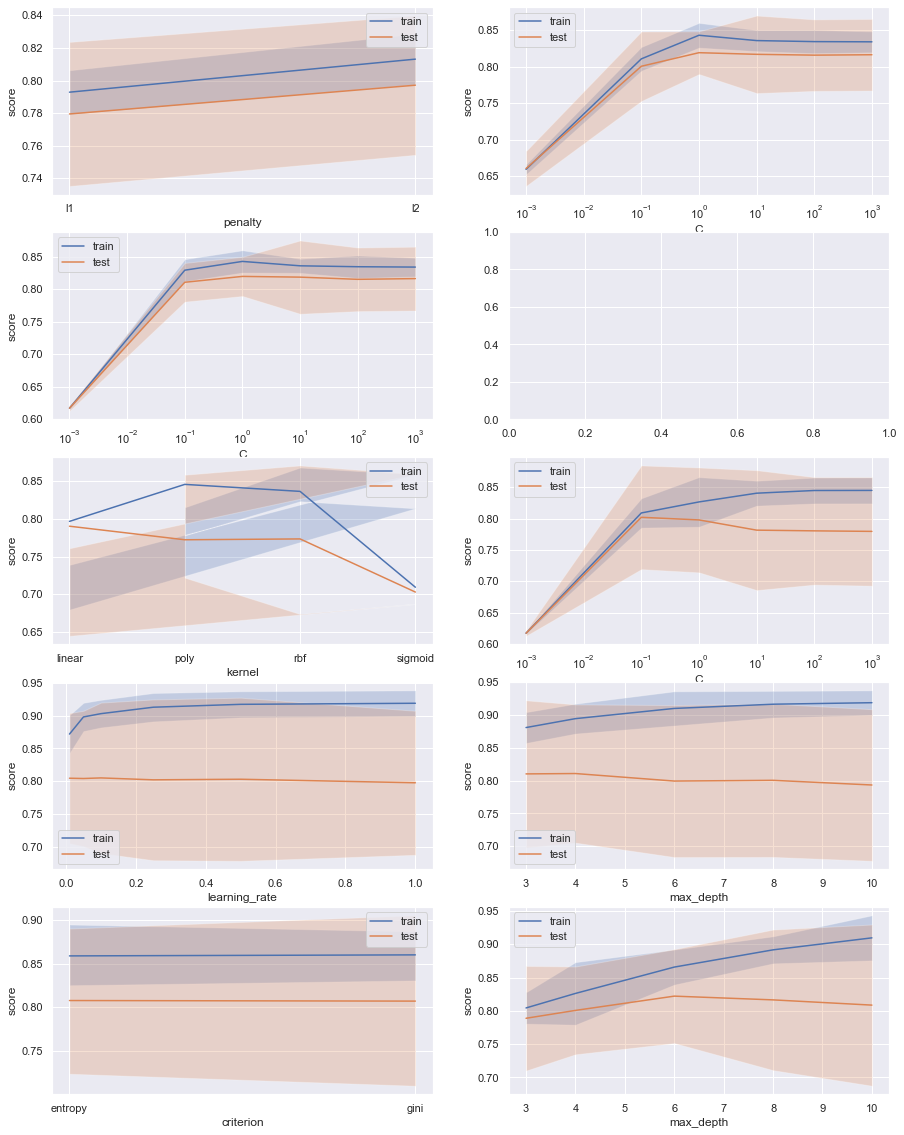

In [116]:
ncols = max([np.sum([1 for p_ in list(p.values()) if len(p_) > 1]) for p in params])
nrows = len(params)
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=(15,20))

for i,p in enumerate(params):
    clf = str(p['clf'][0])#.split('(')[0]
    prms = list(p.keys())[1:]
    df_grp = df_tuning[df_tuning.model_num == i]

    j = 0
    for idx, (param_name, param_range) in enumerate(list(p.items())[1:]):
        grouped_df = df_grp.groupby(f'{param_name}')[results]\
             .agg({'mean_train_score': 'mean',
                    'mean_test_score': 'mean',
                    'std_train_score': combined_std,
                    'std_test_score': combined_std})
        if len(grouped_df) < 2:
            continue

        sns.lineplot(data = grouped_df, x = grouped_df.index, y = 'mean_train_score', label = 'train', ax = ax[i,j])
        sns.lineplot(data = grouped_df, x = grouped_df.index, y = 'mean_test_score', label = 'test', ax = ax[i,j])
        ax[i,j].fill_between(
            x = param_range,
            y1 = grouped_df.mean_train_score + grouped_df.std_train_score, 
            y2 = grouped_df.mean_train_score - grouped_df.std_train_score, 
            alpha = 0.25)
        ax[i,j].fill_between(
            x = param_range,
            y1 = grouped_df.mean_test_score + grouped_df.std_test_score, 
            y2 = grouped_df.mean_test_score - grouped_df.std_test_score, 
            alpha = 0.25)
        ax[i,j].set_ylabel('score')
        ax[i,j].set_xlabel(param_name[5:])
        if all([type(_) != str for _ in param_range]) and (max(param_range) - min(param_range)) > 100:
            ax[i,j].set_xscale('log')
        j += 1


In [128]:
df_tuning[(df_tuning.model_num == 2) & (df_tuning.clf__C == 1.0)]

,mean_test_score,mean_train_score,std_test_score,std_train_score,classifier,model_num,clf__C,clf__penalty,clf__solver,clf__kernel,clf__learning_rate,clf__max_depth,clf__criterion
26,0.815318,0.876126,0.030493,0.008816,"SVC(C=1, probability=True)",2,1.0,NaN,NaN,poly,NaN,NaN,NaN
27,0.827709,0.859799,0.017259,0.009589,"SVC(C=1, probability=True)",2,1.0,NaN,NaN,rbf,NaN,NaN,NaN
28,0.720720,0.735925,0.014961,0.014242,"SVC(C=1, probability=True)",2,1.0,NaN,NaN,sigmoid,NaN,NaN,NaN
29,0.827709,0.834460,0.017259,0.004282,"SVC(C=1, probability=True)",2,1.0,NaN,NaN,linear,NaN,NaN,NaN


In [110]:
from sklearn.model_selection import validation_curve
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores, test_scores = validation_curve(
            estimator = LogisticRegression(solver = 'liblinear', max_iter=1000), 
            X = X_train, y = y_train,
            param_name = 'C', param_range = C_vals,
           # fit_params = {'C' : [0.001, 0.1, 1, 10, 100]},
        )

Text(0.5, 0, 'C')

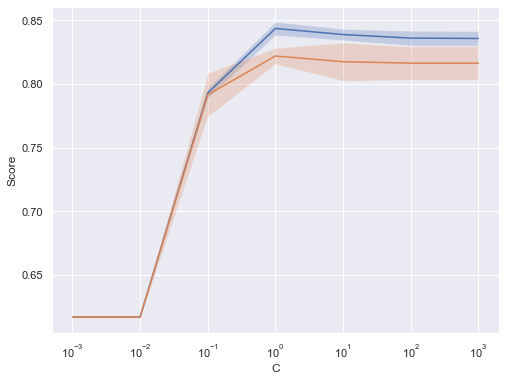

In [111]:
means = [np.mean(train_scores, axis = 1), np.mean(test_scores, axis = 1)]
stds = [np.std(train_scores, axis = 1), np.std(test_scores, axis = 1)]

fig, ax = plt.subplots(figsize=(8,6))
for mean, std in zip(means, stds):
    sns.lineplot(
        x = C_vals, 
        y = mean,
        ax = ax
        )#err_kws = {
        #   'x': C_vals, 
        #   'y1': train_scores_mean - train_scores_std, 
        #   'y2': train_scores_mean + train_scores_std})
    ax.fill_between(
        x = C_vals,
        y1 = mean + std, 
        y2 = mean - std, 
        alpha = 0.25)

ax.set_xscale('log')
ax.set_ylabel('Score')
ax.set_xlabel('C')

# To Do
Model tuning